<h1 align="center">Итоговый проект</h1>

<h2 align="center">По курсу "Аналитик данных (Data scientist)"</h2>

<h3 align="Center">Выполнил: Олексин Иван Викторович, группа AD11902/2</h3>

<h3 align="center">МГТУ им. Н.Э. Баумана, 2022 г.</h3>

<h3><center>Кейс проекта: "Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения"</center></h3>

<h3>1. Постановка задачи</h3>

<b>1.1. Описание кейса</b>

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке:
1.	Снижалась величина сварочного тока (IW);
2.	Увеличивался ток фокусировки электронного пучка (IF);
3.	Увеличивалась скорость сварки (VW);
4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP). 

По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).
В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.


<b>1.2. Задача прогнозирования</b>

Требуется: провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).

<h3>2. Предварительная обработка датасета</h3>

<b>2.1. Загрузка бибилиотек, необходимых для решения задачи</b>

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import tensorflow as tf
from phik.report import plot_correlation_matrix
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor


sns.set(rc={'figure.figsize': (20, 15)})
sns.set_theme(style='white', palette=None)
sns.set_context('talk')
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth=None

<b>2.2. Загрузка и первичное описание датасета</b>

In [2]:
df = pd.read_csv('dataset/ebw_data.csv')
df.head(1)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.50,80,1.60,2.54


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [4]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.00,72.00,72.00,72.00,72.00,72.00
mean,45.67,141.33,8.64,78.33,1.20,1.97
std,1.68,5.15,2.06,21.49,0.23,0.28
min,43.00,131.00,4.50,50.00,0.80,1.68
25%,44.00,139.00,8.00,60.00,1.08,1.76
50%,45.50,141.00,9.00,80.00,1.20,1.84
75%,47.00,146.00,10.00,80.00,1.29,2.05
max,49.00,150.00,12.00,125.00,1.76,2.60


Размеры датасета - 72 строки на 6 столбцов. Типы данных - вещественные и целочисленные.

<b>2.3. Очистка датасета от пропусков и дубликатов</b>

In [5]:
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

Пропуски отсутствуют

In [6]:
df.duplicated().sum()

7

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      65 non-null     int64  
 1   IF      65 non-null     int64  
 2   VW      65 non-null     float64
 3   FP      65 non-null     int64  
 4   Depth   65 non-null     float64
 5   Width   65 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.6 KB


После анализа на пропуски и удаления дубликатов в датасете осталось 65 строк и 6 столбцов

<b>2.4. Анализ датасета на выбросы</b>

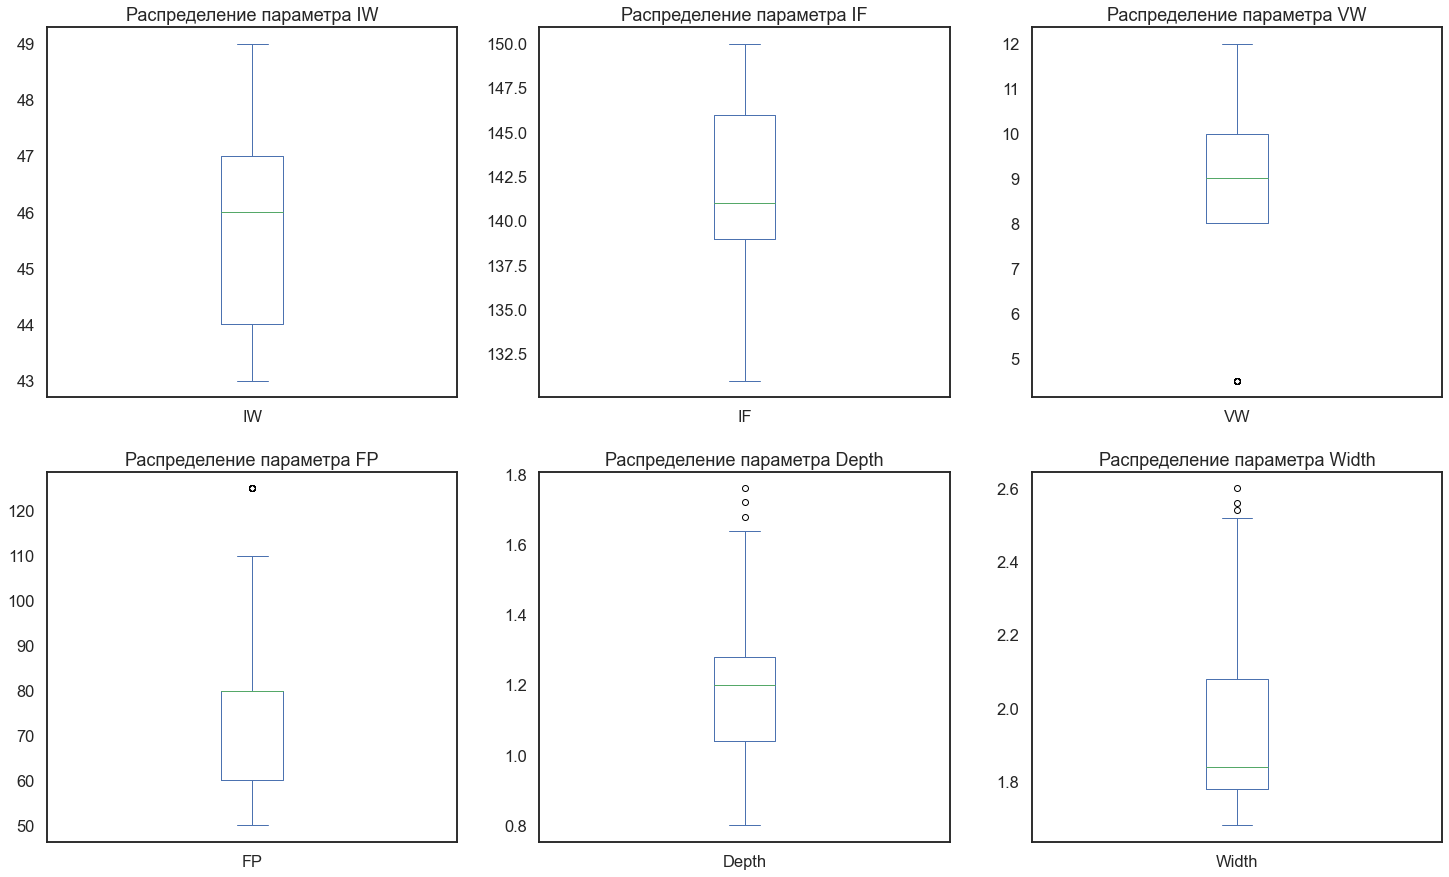

In [9]:
for idx, col in enumerate(df.columns.to_list()):
    df[col].plot(
        kind='box', grid=False, 
        title='Распределение параметра ' + col, 
        figsize=(25,15), ax=plt.subplot(2, 3, idx + 1)
    )

В четырех столбцах наблюдаются потенциальные кандидаты на выбросы.<br/>
Для оценки их влияния на выборку, воспользуемся правилом трех сигм.<br/>
Чтобы найти количество отклонений от среднего значения, рассчитаем z-оценку.

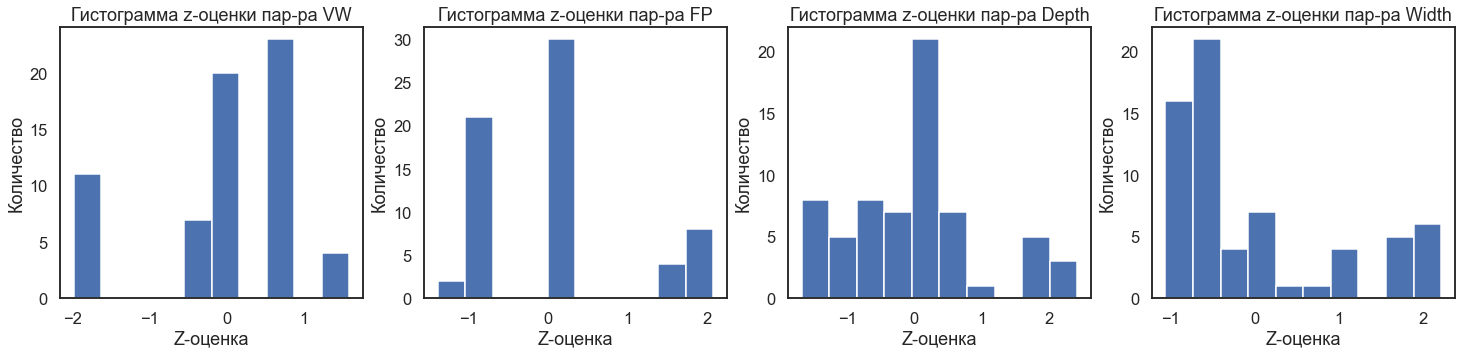

In [10]:
cols = ['VW', 'FP', 'Depth', 'Width']
plt.figure(figsize=(25,5))
for idx, col in enumerate(cols):
    z_val = (df[col] - df[col].mean()) / df[col].std()
    ax = plt.subplot(1, 4, idx + 1)
    plt.title(f'Гистограмма z-оценки пар-ра {col}')
    plt.xlabel('Z-оценка')
    plt.ylabel('Количество')
    plt.hist(z_val)

Все потенциальные выбросы находятся в пределах диапазона трех сигм, в связи с чем их удаление из датасета не является целесообразным

<b>2.5 Анализ влияния признаков на целевые параметры</b>

В целях выявления потенциальных корреляций построим матрицу попарного сравнения

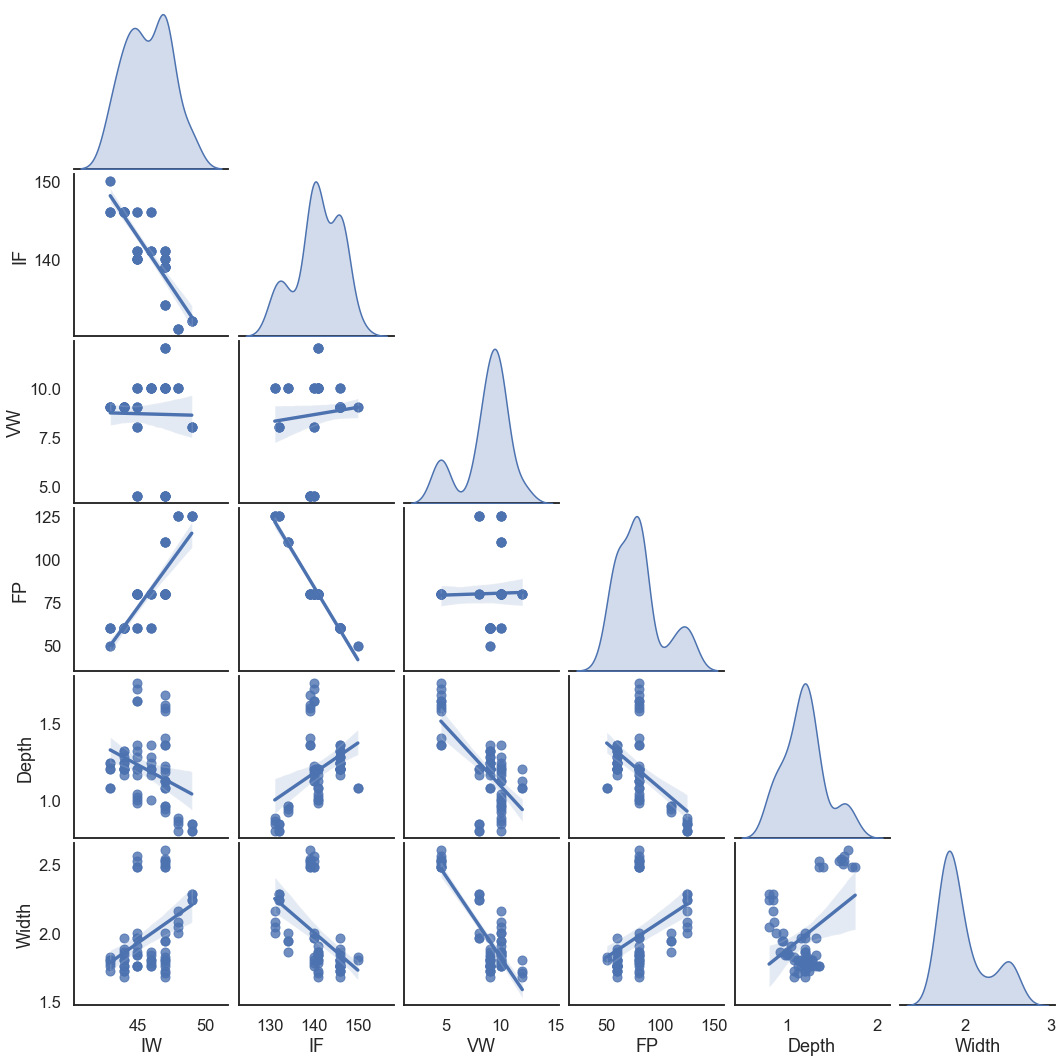

In [11]:
sns.pairplot(df, corner=True, kind='reg', diag_kind='kde')

Построим "Тепловую карту" (heatmap) для оценки корреляции

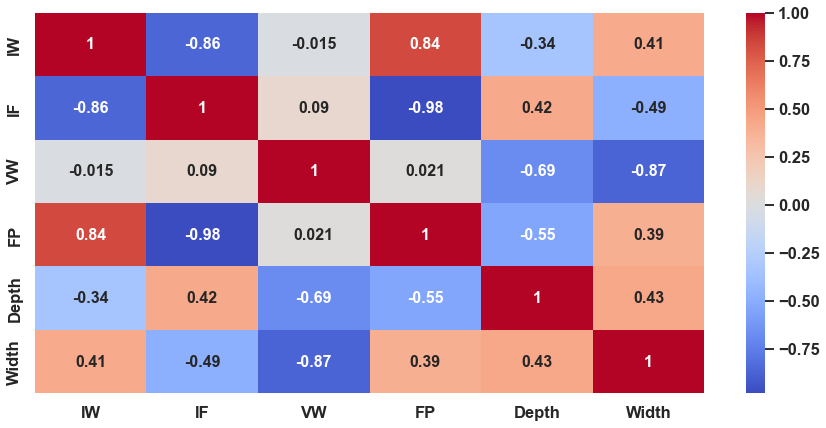

In [12]:
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm');

Матрица корреляции показывает для глубины сварного шва:

- заметную обратную зависимость со скоростью сварки (VW);
- умеренную обратную зависимость с расстоянием от поверхности образцов до электронно-оптической системы (FP) и глубиной шва;
- умеренную зависимость с током фокусировки электронного пучка (IF); для ширина сварного шва:
- высокую обратную зависимость со скоростью сварки (VW);
- умеренную обратную зависимость с током фокусировки электронного пучка (IF);
- умеренную зависимость с величиной сварочного тока (IW).

Между собой целевые переменные показывают умеренную корреляцию. Также можно отметить, что признаки величина сварочного тока (IW) и ток фокусировки электронного пучка (IF) показывают высокую обратную корреляцию между собой и высокую корреляцию с признаком расстояние от поверхности образцов до электронно-оптической системы (FP).

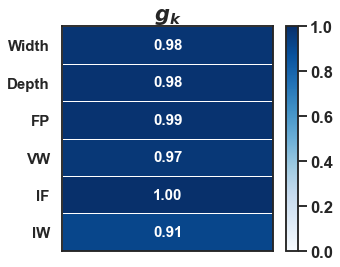

In [13]:
global_correlation, global_labels = df.global_phik(interval_cols=['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'])

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(5,4),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

Высокие значения глобальной корреляции для каждого признака говорят о том, что каждый признак можно выразить через другие.<br/> 
<i>Таким образом, целевые параметры должны хорошо поддаваться прогнозированию</i>

<h3>3. Применение алгоритмов машинного обучения для решения поставленной задачи</h3>

Подготовим тестовый и обучающий наборы данных

In [14]:
X = df[['IW','IF','VW','FP']]
YD = df['Depth']
YW = df['Width']
RND = random.randint(1, 100)
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(X, YD, test_size=0.15, random_state=RND)
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(X, YW, test_size=0.15, random_state=RND)
RND

97

<b>3.1. Линейная регрессия</b>

In [15]:
comparison_list_d = []
comparison_list_w = []

In [16]:
regressor_d = LinearRegression()
regressor_d.fit(x_train_d, y_train_d)

regressor_w = LinearRegression()
regressor_w.fit(x_train_w, y_train_w)

y_pred_d = regressor_d.predict(x_test_d)
y_pred_w = regressor_w.predict(x_test_w)

err_d = mean_absolute_error(y_test_d, y_pred_d)
err_w = mean_absolute_error(y_test_w, y_pred_w)

print("Ошибка предсказания признака Depth:", err_d)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_d.append(('LinearRegression', err_d))
comparison_list_w.append(('LinearRegression', err_w))

Ошибка предсказания признака Depth: 0.06426251477843427
Ошибка предсказания признака Width: 0.05970633755269426


Судя по результатам ошибки для линейной регрессии, ширина шва поддается прогнозированию значительно лучше, чем глубина 

<b>3.2. Дерево решений</b>

In [17]:
regressor_d = DecisionTreeRegressor(random_state=RND)
regressor_d.fit(x_train_d, y_train_d)

regressor_w = DecisionTreeRegressor(random_state=RND)
regressor_w.fit(x_train_w, y_train_w)

y_pred_d = regressor_d.predict(x_test_d)
y_pred_w = regressor_w.predict(x_test_w)

err_d = mean_absolute_error(y_test_d, y_pred_d)
err_w = mean_absolute_error(y_test_w, y_pred_w)

print("Ошибка предсказания признака Depth:", err_d)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_d.append(('DecisionTreeRegressor', err_d))
comparison_list_w.append(('DecisionTreeRegressor', err_w))

Ошибка предсказания признака Depth: 0.053333333333333385
Ошибка предсказания признака Width: 0.036666666666666736


<b>3.3. Полиноминальная регрессия</b>

In [18]:
poly_reg_d = PolynomialFeatures(degree = 3)
X_poly_d = poly_reg_d.fit_transform(x_train_d)
regressor_d = LinearRegression()
regressor_d.fit(X_poly_d, y_train_d)

poly_reg_w = PolynomialFeatures(degree = 3)
X_poly_w = poly_reg_w.fit_transform(x_train_w)
regressor_w = LinearRegression()
regressor_w.fit(X_poly_w, y_train_w)

y_pred_d = regressor_d.predict(poly_reg_d.transform(x_test_d))
y_pred_w = regressor_w.predict(poly_reg_w.transform(x_test_w))

err_d = mean_absolute_error(y_test_d, y_pred_d)
err_w = mean_absolute_error(y_test_w, y_pred_w)

print("Ошибка предсказания признака Depth:", err_d)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_d.append(('PolynomialFeatures', err_d))
comparison_list_w.append(('PolynomialFeatures', err_w))

Ошибка предсказания признака Depth: 0.05213186645507811
Ошибка предсказания признака Width: 0.03794982910156253


<b>3.4. Случайный лес</b>

In [19]:
regressor_d = RandomForestRegressor(n_estimators = 5,random_state=RND)
regressor_d.fit(x_train_d, y_train_d)

regressor_w = RandomForestRegressor(n_estimators = 5,random_state=RND)
regressor_w.fit(x_train_w, y_train_w)

y_pred_d = regressor_d.predict(x_test_d)
y_pred_w = regressor_w.predict(x_test_w)

err_d = mean_absolute_error(y_test_d, y_pred_d)
err_w = mean_absolute_error(y_test_w, y_pred_w)

print("Ошибка предсказания признака Depth:", err_d)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_d.append(('RandomForestRegressor', err_d))
comparison_list_w.append(('RandomForestRegressor', err_w))

Ошибка предсказания признака Depth: 0.06310253968253973
Ошибка предсказания признака Width: 0.04784539682539683


<b>3.5 К-Ближайших соседей</b>

In [20]:
regressor_d = KNeighborsRegressor(n_neighbors=5, algorithm='auto')
regressor_d.fit(x_train_d, y_train_d)

regressor_w = KNeighborsRegressor(n_neighbors=5, algorithm='auto')
regressor_w.fit(x_train_w, y_train_w)

y_pred_d = regressor_d.predict(x_test_d)
y_pred_w = regressor_w.predict(x_test_w)

err_d = mean_absolute_error(y_test_d, y_pred_d)
err_w = mean_absolute_error(y_test_w, y_pred_w)

print("Ошибка предсказания признака Depth:", err_d)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_d.append(('KNeighbors', err_d))
comparison_list_w.append(('KNeighbors', err_w))

Ошибка предсказания признака Depth: 0.04799999999999997
Ошибка предсказания признака Width: 0.044399999999999995


Все алгоритмы машинного обучения показывают приблизительно одинаковый уровень ошибки и при этом являются более подходящими, чем простая линейная регрессия

Перейдем к анализу с помощью искусственных нейронных сетей для оценки их применимости при решении данной задачи

Text(0.5, 1.0, 'Ошибка для параметра "Ширина шва (Width)"')

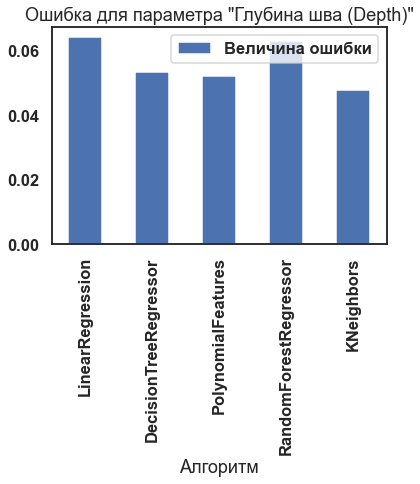

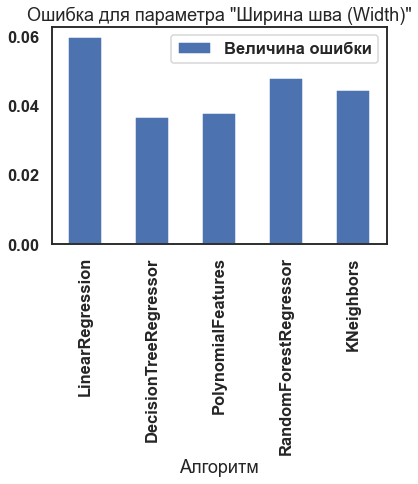

In [21]:
pd.DataFrame(comparison_list_d, columns=['Алгоритм', 'Величина ошибки']).plot(kind='bar', x='Алгоритм')
plt.title('Ошибка для параметра "Глубина шва (Depth)"')
pd.DataFrame(comparison_list_w, columns=['Алгоритм', 'Величина ошибки']).plot(kind='bar', x='Алгоритм')
plt.title('Ошибка для параметра "Ширина шва (Width)"')

<b>3.6 Использование искусственных нейронных сетей</b>

In [22]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.2])
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.002))
    return model

dnn_model = build_and_compile_model(normalizer)

1/1 [==============================] - 0s 64ms/step
Ошибка предсказания признака Depth: 0.04993497562408446


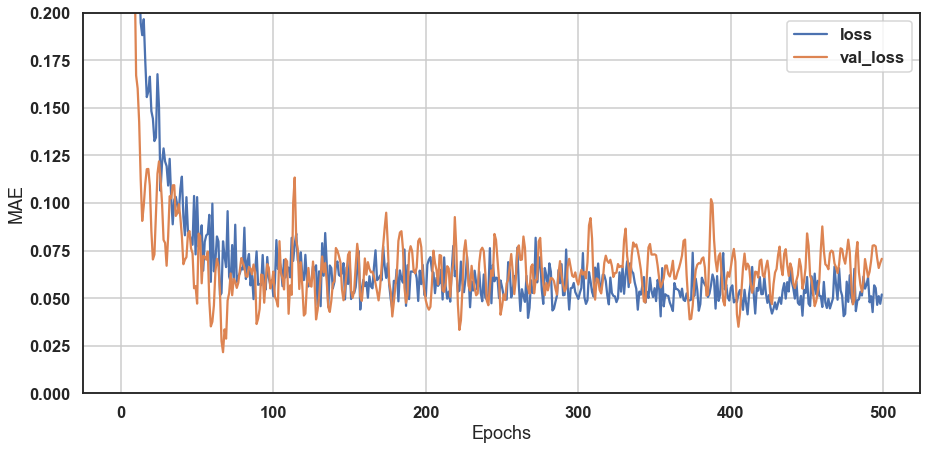

In [23]:
history = dnn_model.fit(
    x_train_d,
    y_train_d,
    epochs=500,
    verbose=0,
    validation_split = 0.1)

plt.figure(figsize=(15,7))
plot_loss(history)

y_pred_d = dnn_model.predict(x_test_d)
err_d = mean_absolute_error(y_test_d, y_pred_d)
print("Ошибка предсказания признака Depth:", err_d)

comparison_list_d.append(('NeuralNetwork', err_d))

1/1 [==============================] - 0s 11ms/step
Ошибка предсказания признака Width: 0.05154713249206546


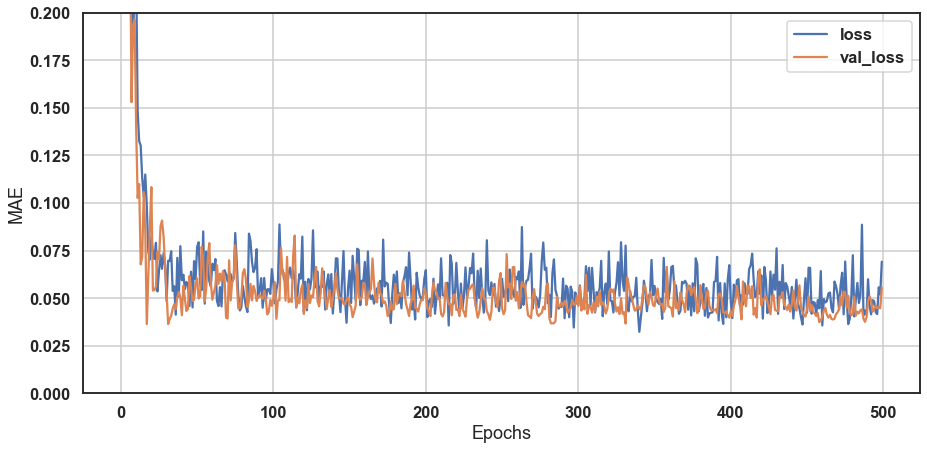

In [24]:
history = dnn_model.fit(
    x_train_w,
    y_train_w,
    epochs=500,
    verbose=0,
    validation_split = 0.1)

plt.figure(figsize=(15,7))
plot_loss(history)

y_pred_w = dnn_model.predict(x_test_w)
err_w = mean_absolute_error(y_test_w, y_pred_w)
print("Ошибка предсказания признака Width:", err_w)

comparison_list_w.append(('NeuralNetwork', err_w))

Text(0.5, 1.0, 'Ошибка для параметра "Ширина шва (Width)"')

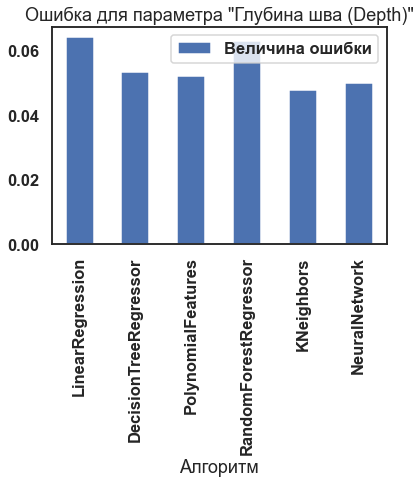

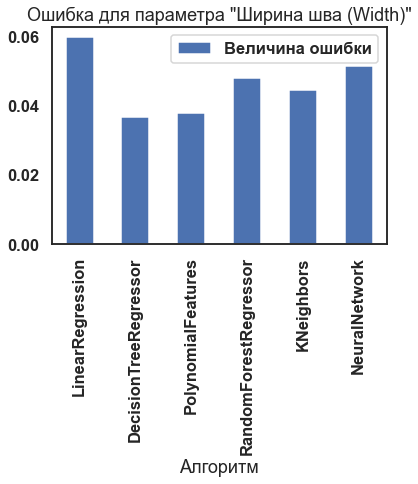

In [25]:
pd.DataFrame(comparison_list_d, columns=['Алгоритм', 'Величина ошибки']).plot(kind='bar', x='Алгоритм')
plt.title('Ошибка для параметра "Глубина шва (Depth)"')
pd.DataFrame(comparison_list_w, columns=['Алгоритм', 'Величина ошибки']).plot(kind='bar', x='Алгоритм')
plt.title('Ошибка для параметра "Ширина шва (Width)"')

<h3>4. Выбор, обучение, сохранение модели</h3>

Проранжируем результаты по величине ошибки

In [33]:
pd.options.display.float_format = '{:.5f}'.format
df_err_d = pd.DataFrame(comparison_list_d, columns=['Алгоритм', 'Величина ошибки Depth']).sort_values(by='Алгоритм')
df_err_w = pd.DataFrame(comparison_list_w, columns=['Алгоритм', 'Величина ошибки Width']).sort_values(by='Алгоритм')
df_err_both = df_err_w
df_err_both['Величина ошибки Depth'] = df_err_d['Величина ошибки Depth']
df_err_both['Средняя ошибка по двум параметрам'] = (df_err_both['Величина ошибки Width']+df_err_both['Величина ошибки Depth'])/2
df_err_both.sort_values(by='Средняя ошибка по двум параметрам')

,Алгоритм,Величина ошибки Width,Величина ошибки Depth,Средняя ошибка по двум параметрам
1,DecisionTreeRegressor,0.03667,0.05333,0.04500
2,PolynomialFeatures,0.03795,0.05213,0.04504
4,KNeighbors,0.04440,0.04800,0.04620
5,NeuralNetwork,0.05155,0.04993,0.05074
3,RandomForestRegressor,0.04785,0.06310,0.05547
0,LinearRegression,0.05971,0.06426,0.06198


В данной ситуации нейросеть не показывает какого-либо преимущества над другими алгоритмами машинного обучения

Алгоритм DecisionTreeRegressor смог дать наиболее предпочтительные показатели, поэтому будем использовать его в финальной версии приложения

In [27]:
model_d = DecisionTreeRegressor(random_state=RND)
model_d.fit(X, YD)

model_w= DecisionTreeRegressor(random_state=RND)
model_w.fit(X, YW)

DecisionTreeRegressor(random_state=97)

In [28]:
with open('model_d.pkl','wb') as d:
    pickle.dump(model_d,d)
    
with open('model_w.pkl','wb') as w:
    pickle.dump(model_w,w)    